# Bank Customer Classification
## Given a dataset consisiting of Bank Customer information, we are asked to build a classifier which will tell us if a customer will exit the bank or not.

In [1]:
!pip install scikit-learn==0.22.0

    100% |████████████████████████████████| 7.0MB 5.0MB/s 
lime 0.1.1.33 has requirement matplotlib==2.1.0, but you'll have matplotlib 3.0.3 which is incompatible.
kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.5.0.dev0 which is incompatible.
kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.16.3 which is incompatible.
kmeans-smote 0.1.2 has requirement scikit-learn<0.21,>=0.19.0, but you'll have scikit-learn 0.22 which is incompatible.
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

import os
print(os.listdir("../input"))

['Churn_Modelling.csv']


# Data Preprocessing 

### In this dataset, we have to consider which of the factors may play a role in someone exiting a bank. To do that we must look at all  the column and infer whether it will matter in classifying a new customer or not.  The information about a customer is entailed in columns 0 through 12 (RowNumber-EstimatedSalary), while the output (whether the customer exited or not) is stored in the 13th row (Exited). 

For as much as we care, neither the customer ID, nor the surname should matter in classification. 
Therefore, we will use columns 3 (CreditScore) inclusive through the 13th column (exclusive).


In [3]:
#importing the dataset
dataset = pd.read_csv('../input/Churn_Modelling.csv', index_col='RowNumber')
dataset.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
X_columns = dataset.columns.tolist()[2:12]
y_columns = dataset.columns.tolist()[-1:]
print(f'All columns: {dataset.columns.tolist()}')
print()
print(f'X values: {X_columns}')
print()
print(f'y values: {y_columns}')

All columns: ['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

X values: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

y values: ['Exited']


In [5]:
X = dataset[X_columns].values # Credit Score through Estimated Salary
y = dataset[y_columns].values # Exited

In [6]:
# Encoding categorical (string based) data. Country: there are 3 options: France, Spain and Germany
# This will convert those strings into scalar values for analysis
print(X[:8,1], '... will now become: ')
from sklearn.preprocessing import LabelEncoder
label_X_country_encoder = LabelEncoder()
X[:,1] = label_X_country_encoder.fit_transform(X[:,1])
print(X[:8,1])

['France' 'Spain' 'France' 'France' 'Spain' 'Spain' 'France' 'Germany'] ... will now become: 
[0 2 0 0 2 2 0 1]


In [7]:
# We will do the same thing for gender. this will be binary in this dataset
print(X[:6,2], '... will now become: ')
from sklearn.preprocessing import LabelEncoder
label_X_gender_encoder = LabelEncoder()
X[:,2] = label_X_gender_encoder.fit_transform(X[:,2])
print(X[:6,2])

['Female' 'Female' 'Female' 'Female' 'Female' 'Male'] ... will now become: 
[0 0 0 0 0 1]


The Problem here is that we are treating the countries as one variable with ordinal values (0 < 1 <  2). Therefore, one way to get rid of that problem is to split the countries into respective dimensions. that is,

| Country |  -> | Country|-> |Spain|France|Germany|
|------|      |------|  |------|    |------|    |------|
|   Spain |   -> |0| -> |1|0|0|
|   France | -> |1| -> |0|1|0|
|   France | ->  |1| -> |0|1|0|
|   Germany | -> |2| -> |0|0|1|

You can now see that the first three columns represent the three countries that constituted the "country" category. We can now observe that  we essentially only need two columns: a 0 on two countries means that the country has to be the one variable which wasn't included. This will save us from the problem of using too many dimensions.

|Spain|France|Germany|-> |France|Germany|
 |------|    |------|    |------|     |------|     |------|
 |1|0|0|-> |0|0|
|0|1|0|-> |1|0|
|0|1|0|-> |1|0|
|0|0|1|-> |0|1|

We have achieved this using the `drop='first'` option in the OneHotEncoder

Feature scaling is a method used to standardize the range of independent variables or features of data. It is basically scaling all the dimensions to be even so that one independent variable does not dominate another. For example, bank account balance ranges from millions to 0, whereas gender is either 0 or 1. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


pipeline = Pipeline(
    [('Categorizer', ColumnTransformer(
         [ # Gender
          ("Gender Label encoder", OneHotEncoder(categories='auto', drop='first'), [2]),
           # Geography
          ("Geography One Hot", OneHotEncoder(categories='auto', drop='first'), [1])
         ], remainder='passthrough', n_jobs=1)),
     # Standard Scaler for the classifier
    ('Normalizer', StandardScaler())
    ])

In [9]:
X = pipeline.fit_transform(X)

In [10]:
# Splitting the dataset into the Training and Testing set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [11]:
print(f'training shapes: {X_train.shape}, {y_train.shape}')
print(f'testing shapes: {X_test.shape}, {y_test.shape}')

training shapes: (8000, 11), (8000, 1)
testing shapes: (2000, 11), (2000, 1)


## END OF PREPROCESSING

## Making the NN

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [13]:
# Initializing the ANN
classifier = Sequential()

A hurestic tip is that the amount of nodes (dimensions) in your hidden layer should be the average of your input and output layers, which means that since we have 11 dimensions (representing **Independent variables** Note: Countries still compose only  **one** dimension) and we are looking for a binary output, we calculate this to be $(11+1)\div 2 = 6 $.

#### The breakdown of the inputs for the first layer is as follows:

`units`: `6` nodes (number of nodes in hidden layer). Can think of this as number of nodes are in the next layer.

`activiation`: `relu` becasue we are in an input layer. uses the ReLu activation function for the layer. This is equivalent to $max(0, W \times x^T + b)$

`input_dim`: `11` because we span 11 dimensions in our input layer. This is needed for the first added layer. The subsequent layers's input dimensions can be inferred using the previously added layer's output dimension. The next hidden layer will know what to expect.




In [14]:
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
classifier.add(Dense(6, activation = 'relu', input_shape = (X_train.shape[1], )))
classifier.add(Dropout(rate=0.1)) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### We are going to add another layer to this model because we want to implement Deep Learning, which is an artificial Neural network with many layers.
We will make our second hidden layer also have 6 nodes, just playing with the same arithmetic we used to determine the dimensions of the first hidden layer (average of your input and output layers) $(11+1)\div 2 = 6 $.

In [15]:
# Adding the second hidden layer
# Notice that we do not need to specify input dim. 
classifier.add(Dense(6, activation = 'relu')) 
classifier.add(Dropout(rate=0.1)) 

### Adding the output layer
#### The breakdown of the inputs for the output layer is as follows:

*activiation*: **sigmoid** becasue we are in an output layer. uses the Sigmoid activation function for $\phi$. This is used instead of the ReLu function becasue it generates probabilities for the outcome. We want the probability that each customer leaves the bank.  

`units`: `6` nodes (number of nodes in hidden layer). Can think of this as number of nodes are in the next layer.

`input_dim`: `11` because we span 11 dimensions in our input layer. This is needed for the first added layer. The subsequent layers's input dimensions can be inferred using the previously added layer's output dimension. The next hidden layer will know what to expect.


In [16]:
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
# We use the sigmoid because we want probability outcomes
classifier.add(Dense(1, activation = 'sigmoid')) 


### If we want more than two categories, then we will need to change 

 1) the *units* parameter to match the desired category count
 
 2) the *activation* field to **softmax**.  Basically a sigmoid function but applied to a dependent variable that has more than 2 categories.

In [17]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dropout_2 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


## Compiling the Neural Network
Basically applying Stochastic Gradient descent on the whole Neural Network. We are Tuning the individual weights on each neuron.

#### The breakdown of the inputs for compiling is as follows:

`optimizer`: `adam` The algorithm we want to use to find the optimal set of weights in the neural networks.  Adam is a very efficeint variation of Stochastic Gradient Descent.

`loss`: `binary_crossentropy` This is the loss function used within adam. This should be the logarthmic loss. If our dependent (output variable) is `Binary`, it is `binary_crossentropy`. If `Categorical`, then it is called `categorical_crossentropy`

`metrics`: `[accuracy]` The accuracy metrics which will be evaluated(minimized) by the model. Used as accuracy criteria to imporve model performance. 

In [18]:
classifier.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

## Fitting the Neural Network
This is where we will be fitting the NN to our training set.

#### The breakdown of the inputs for compiling is as follows:

`X_train` The independent variable portion of the data which needs to be fitted with the model.

`Y_train` The output portion of the data which the model needs to produce after fitting.

`batch_size`:  How often we want to back-propogate the error values so that individual node weights can be adjusted. 

`epochs`: The number of times we want to run the entire test data over again to tune the weights. This is like the fuel of the algorithm. 


`validation_split`: `0.2` The fraction of data to use for validation data. 


In [19]:
history = classifier.fit(X_train, y_train, batch_size=32, epochs=200, validation_split=0.1, verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 7200 samples, validate on 800 samples
Epoch 1/200
 - 1s - loss: 0.5674 - acc: 0.7426 - val_loss: 0.4948 - val_acc: 0.7925
Epoch 2/200
 - 0s - loss: 0.4950 - acc: 0.7931 - val_loss: 0.4631 - val_acc: 0.7950
Epoch 3/200
 - 0s - loss: 0.4710 - acc: 0.7964 - val_loss: 0.4425 - val_acc: 0.7937
Epoch 4/200
 - 0s - loss: 0.4528 - acc: 0.7989 - val_loss: 0.4284 - val_acc: 0.7975
Epoch 5/200
 - 0s - loss: 0.4440 - acc: 0.8038 - val_loss: 0.4184 - val_acc: 0.8000
Epoch 6/200
 - 0s - loss: 0.4376 - acc: 0.8058 - val_loss: 0.4111 - val_acc: 0.8075
Epoch 7/200
 - 0s - loss: 0.4278 - acc: 0.8107 - val_loss: 0.4020 - val_acc: 0.8075
Epoch 8/200
 - 0s - loss: 0.4173 - acc: 0.8137 - val_loss: 0.3942 - val_acc: 0.8075
Epoch 9/200
 - 0s - loss: 0.4084 - acc: 0.8149 - val_loss: 0.3880 - val_acc: 0.8087
Epoch 10/200
 - 0s - loss: 0.4089 - acc: 0.8151 - val_loss: 0.3841 - val_acc: 0.8113
Epoch 11/200
 - 0s - loss: 0.4078 - acc: 0.8157 - val_loss: 0.37

The output network should converge to an accuracy of around 85%
## Testing the NN
### Predicting the Test set results

This shows the probability of a customer leaving given the testing data. Each row in X_test corresponds to a row in Y_test

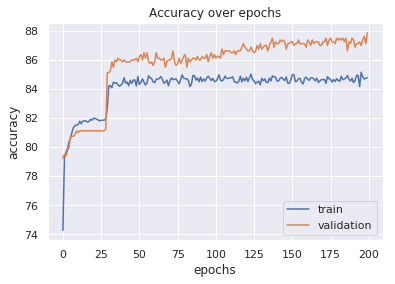

In [20]:
plt.plot(np.array(history.history['acc']) * 100)
plt.plot(np.array(history.history['val_acc']) * 100)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.title('Accuracy over epochs')
plt.show()

In [21]:
y_pred = classifier.predict(X_test)
print(y_pred[:5])

[[0.2788993 ]
 [0.42713052]
 [0.17558068]
 [0.0720844 ]
 [0.09354061]]


To use the confusion Matrix, we need to convert the probabilities that a customer will leave the bank into the form true or false. So we will use the cutoff value 0.5 to indicate whether they are likely to exit or not.

In [22]:
y_pred = (y_pred > 0.5).astype(int)
print(y_pred[:5])

[[0]
 [0]
 [0]
 [0]
 [0]]


### Making the Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1530   65]
 [ 221  184]]


### Significance of the confusion matrix value:

The output should be close to the table below:

||Predicted: No |Predicted: Yes|
 |------| |------|   |------|  
 |Actual: No|1504|91|
|Actual: Yes|184|221


This means that we should have about $(1504 + 221) = 1726$ correct classifications out of our total testing data size of $2000$.
This means that our accuracy for this trial was $1726 \div 2000 = 86.3\%$, which matches the classifier's prediction

In [24]:
print (((cm[0][0]+cm[1][1])*100)/(len(y_test)), '% of testing data was classified correctly')

85.7 % of testing data was classified correctly
